In [115]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [177]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def weighted(x, cols, weight):
    return pd.Series(np.average(x[cols], weights=x[weight], axis=0), cols)

from patsy import dmatrix

def func(x, a, b, c, d):
    return x[:,4] * np.exp(a*x[:,0] + b*x[:,1] + c*x[:,2] + d*x[:,3])
    
def func(x, a, b, c, d):
    fico_a, fico_b, fico_c, fico_d, mod = x
    return mod * (a*fico_a + b*fico_b + c*fico_c + d*fico_d)
    
def check_error(popt):
    #print(np.exp(popt))
    p = func(x, *popt)
    w = df['bal'].to_numpy()
    return p.dot(w) - y.dot(w)

def print_error(popt):
    #print(np.exp(popt))
    print(popt)
    p = func(x, *popt)
    w = df['bal'].to_numpy()
    print(p.dot(w) - y.dot(w))

In [188]:
len = int(1e5)
param = [0.7, 0.1, 0.9, 0.3]
nosie_scale = 1e-2
bal_sigma = 2

def createData(len):
    mod = np.random.rand(len)/30.
    fico = ['A', 'B', 'C', 'D']
    cat = np.random.choice(fico, len, p=[0.55, 0.1, 0.05, 0.3])
    noise = np.random.normal(loc=0.0, scale=nosie_scale, size=len)
    bal = np.random.lognormal(mean=1.0, sigma=bal_sigma, size=int(len))
    
    df = pd.DataFrame({'mod': mod, 'fico': cat, 'noise': noise, 'bal': bal})
    df.loc[df['fico']=='A', 'act'] = param[0] * df['mod'] + df['noise']
    df.loc[df['fico']=='B', 'act'] = param[1] * df['mod'] + df['noise']
    df.loc[df['fico']=='C', 'act'] = param[2] * df['mod'] + df['noise']
    df.loc[df['fico']=='D', 'act'] = param[3] * df['mod'] + df['noise']

    return df

In [179]:
df = createData()
df.head()

,mod,fico,noise,bal,act
0,0.010165,D,-0.013228,25.641746,-0.010179
1,0.017626,D,0.004391,3.374610,0.009679
2,0.023992,D,-0.000431,2.646084,0.006766
3,0.000722,B,-0.008738,36.954072,-0.008665
4,0.022714,D,-0.023424,1.407239,-0.016610


In [70]:
dmatrix('mod + fico - 1', df)

DesignMatrix with shape (100000, 5)
  fico[A]  fico[B]  fico[C]  fico[D]      mod
        1        0        0        0  0.01866
        0        0        1        0  0.01593
        1        0        0        0  0.00541
        1        0        0        0  0.01430
        1        0        0        0  0.03244
        0        0        0        1  0.00759
        0        0        0        1  0.03296
        1        0        0        0  0.00544
        0        0        0        1  0.02060
        0        0        0        1  0.01429
        1        0        0        0  0.01600
        1        0        0        0  0.02692
        1        0        0        0  0.00918
        1        0        0        0  0.01655
        1        0        0        0  0.02178
        0        0        0        1  0.03134
        0        0        0        1  0.00009
        1        0        0        0  0.00303
        1        0        0        0  0.00077
        0        0        0        1  0.0244

# scipy.curve_fit

In [180]:
x = np.array(dmatrix('mod + fico - 1', df)).T
y = df['act'].to_numpy()

error1, error2, error3, erro4 = [], [], [], []

popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=1/np.sqrt(np.array(df['bal'])))
print_error(popt)

[0.70125451 0.11089118 0.93331634 0.29223053]
-37.7530039513731


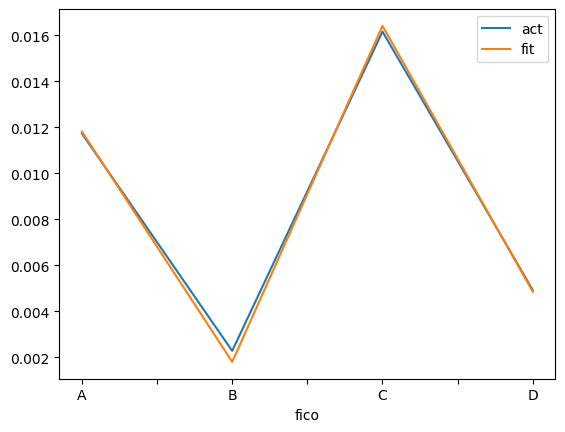

In [182]:
df.loc[:, 'fit'] = func(x, *popt)
res = df.groupby('fico').apply(weighted, ['act', 'fit'], 'bal')
res.plot();

In [187]:
%%time

error1, error2, error3, error4 = [], [], [], []

for i in range(100):
    df = createData()
    x = np.array(dmatrix('mod + fico - 1', df)).T
    y = df['act'].to_numpy()
    
    popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=1/np.sqrt(np.array(df['bal'])))
    error1.append(check_error(popt))
    popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=np.array(df['bal']))
    error2.append(check_error(popt))
    popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=1/np.array(df['bal']))
    error3.append(check_error(popt))
    popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=np.sqrt(np.array(df['bal'])))
    error4.append(check_error(popt))

print(min(error1), np.average(error1), max(error1), np.std(error1))
print(min(error2), np.average(error2), max(error2), np.std(error2))
print(min(error3), np.average(error3), max(error3), np.std(error3))
print(min(error4), np.average(error4), max(error4), np.std(error4))

-1155.437059298678 -39.477791923853914 530.4999913606698 234.7045000905896
-16952.958704975128 -258.9245638323342 13669.157807958974 3987.0287764583272
-7215.1986158793825 794.8905708008261 18071.971506020698 3870.673930838039
-2179.629321733777 -99.34553585296098 950.9286926820714 616.6897270976261
CPU times: total: 36.4 s
Wall time: 36.4 s


# statsmodel glm

In [182]:
df['act_bal'] = df['act'] * df['bal']
df['mod_bal'] = df['mod'] * df['bal']
df['error'] = df['act']/df['mod']

formula = "error ~ C(fico) - 1"
mod1= smf.glm(formula=formula, data=df, family=sm.families.Gaussian(), freq_weights=np.asarray(df['bal'])).fit()
mod1.summary()

formula = "error ~ C(fico) - 1"
mod1= smf.glm(formula=formula, data=df, family=sm.families.Gaussian(), freq_weights=np.asarray(np.sqrt(df['bal']))).fit()
mod1.summary()

formula = "error ~ C(fico) - 1"
mod1= smf.glm(formula=formula, data=df, family=sm.families.Gaussian(), freq_weights=np.asarray(1/np.sqrt(df['bal']))).fit()
mod1.summary()

formula = "error ~ C(fico) - 1"
mod1= smf.glm(formula=formula, data=df, family=sm.families.Gaussian(), freq_weights=np.asarray(1/(df['bal']))).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  error   No. Observations:              1000000
Model:                            GLM   Df Residuals:               4480758.87
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1222.7
Method:                          IRLS   Log-Likelihood:            -2.2284e+07
Date:                Mon, 10 Jul 2023   Deviance:                   5.4787e+09
Time:                        23:36:26   Pearson chi2:                 5.48e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0002032
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(fico)[A]     0.7503      0.022     33.695      0.000       0.707       0.794
C(fico)[B]     0.1546      0.052      2.959      0.003       0.052       0.257
C(fico)[C]     0.9050      0.074     12.245      0.000       0.760       1.050
C(fico)[D]     0.3480      0.030     11.536      0.000       0.289       0.407
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  error   No. Observations:              1000000
Model:                            GLM   Df Residuals:               1868470.56
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1616.5
Method:                          IRLS   Log-Likelihood:            -9.5534e+06
Date:                Mon, 10 Jul 2023   Deviance:                   3.0204e+09
Time:                        23:36:30   Pearson chi2:                 3.02e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          5.697e-05
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(fico)[A]     0.7308      0.040     18.434      0.000       0.653       0.808
C(fico)[B]     0.2221      0.093      2.390      0.017       0.040       0.404
C(fico)[C]     0.9060      0.132      6.867      0.000       0.647       1.165
C(fico)[D]     0.3296      0.054      6.133      0.000       0.224       0.435
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  error   No. Observations:              1000000
Model:                            GLM   Df Residuals:                686913.41
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          2323.7
Method:                          IRLS   Log-Likelihood:            -3.6368e+06
Date:                Mon, 10 Jul 2023   Deviance:                   1.5962e+09
Time:                        23:36:33   Pearson chi2:                 1.60e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          9.045e-06
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(fico)[A]     0.6554      0.078      8.362      0.000       0.502       0.809
C(fico)[B]     0.4824      0.184      2.624      0.009       0.122       0.843
C(fico)[C]     0.9035      0.261      3.463      0.001       0.392       1.415
C(fico)[D]     0.3060      0.106      2.880      0.004       0.098       0.514
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  error   No. Observations:              1000000
Model:                            GLM   Df Residuals:                605778.39
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          2300.5
Method:                          IRLS   Log-Likelihood:            -3.2042e+06
Date:                Mon, 10 Jul 2023   Deviance:                   1.3936e+09
Time:                        23:36:37   Pearson chi2:                 1.39e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          6.989e-06
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(fico)[A]     0.6367      0.083      7.666      0.000       0.474       0.799
C(fico)[B]     0.5533      0.195      2.839      0.005       0.171       0.935
C(fico)[C]     0.8946      0.275      3.248      0.001       0.355       1.434
C(fico)[D]     0.3154      0.113      2.800      0.005       0.095       0.536
==============================================================================
"""

# minuit

bug in init function of LeastSquares

```
#self._ndim = x.ndim   
self._ndim = x.shape[0] 
```

In [154]:
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit

param = [0.7, 0.1, 0.9, 0.3]

def func(x, a, b, c, d):
    fico_a, fico_b, fico_c, fico_d, mod = x
    return mod * (a*fico_a + b*fico_b + c*fico_c + d*fico_d)

In [183]:
# generate random toy data with random offsets in y
x = np.array(dmatrix('mod + fico - 1', df)).T
y = df['act'].to_numpy()

yerr = 1/np.sqrt(np.array(df['bal']))

least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func3)
m = Minuit(least_squares, a=0, b=0, c=0, d=0)  # starting values for α and β
m.migrad()  # finds minimum of least_squares function
#m.hesse()   # accurately computes uncertainties
popt = list(m.values.to_dict().values())
print(popt)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 195.2 (χ²/ndof = 0.0)      │              Nfcn = 47               │
│ EDM = 1.21e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.70    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   0.11    │   0.11    │            │            │         │         │       │
│ 2 │ c    │   0.93    │   0.17    │            │            │         │         │       │
│ 3 │ d    │   0.29    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────┐
│   │       a       b       c       d │
├───┼─────────────────────────────────┤
│ a │ 0.00243 -0.0000 -0.0000  0.0000 │
│ b │ -0.0000  0.0125   0.000  -0.000 │
│ c │ -0.0000   0.000  0.0274  -0.000 │
│ d │  0.0000  -0.000  -0.000 0.00434 │
└───┴─────────────────────────────────┘

[0.7012544973347058, 0.11089117963225754, 0.9333163405436353, 0.29223053563100443]


In [169]:
%%time

error1, error2, error3, error4 = [], [], [], []

for i in range(100):
    df = createData()
    x = np.array(dmatrix('mod + fico - 1', df)).T
    y = df['act'].to_numpy()

    yerr = 1/np.sqrt(np.array(df['bal']))
    least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
    m = Minuit(least_squares, a=0, b=0, c=0, d=0)
    _ = m.migrad()
    popt = list(m.values.to_dict().values())
    error1.append(check_error(popt))

    yerr = 1/np.array(df['bal'])
    least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
    m = Minuit(least_squares, a=0, b=0, c=0, d=0)
    _ = m.migrad()
    popt = list(m.values.to_dict().values())
    error2.append(check_error(popt))

    yerr = np.sqrt(np.array(df['bal']))
    least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
    m = Minuit(least_squares, a=0, b=0, c=0, d=0)
    _ = m.migrad()
    popt = list(m.values.to_dict().values())
    error3.append(check_error(popt))    

    yerr = np.array(df['bal'])
    least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
    m = Minuit(least_squares, a=0, b=0, c=0, d=0)
    _ = m.migrad()
    popt = list(m.values.to_dict().values())
    error4.append(check_error(popt))

print(min(error1), np.average(error1), max(error1), np.std(error1))
print(min(error2), np.average(error2), max(error2), np.std(error2))
print(min(error3), np.average(error3), max(error3), np.std(error3))
print(min(error4), np.average(error4), max(error4), np.std(error4))

-554.9360796734109 11.831583183823895 722.3679067717894 200.60211046839515
-14126.096723512093 -548.6406355565206 7589.573642048141 3357.3353283735537
-1230.4720070923831 152.8612757416794 1566.606519259134 613.2549973352499
-10615.75293024044 445.5494197523374 13848.039183861263 3876.7741093295604
CPU times: total: 45.4 s
Wall time: 45.5 s


# lmfit

In [255]:
from lmfit import minimize, Parameters

param = [0.7, 0.1, 0.9, 0.3]

def residual(params, x, data, uncertainty):
    fico_0, fico_1, fico_2, fico_3, mod = x

    ficoA = params['ficoA']
    ficoB = params['ficoB']
    ficoC = params['ficoC']
    ficoD = params['ficoD']

    #model = mod * np.exp(fico_0 * ficoA + fico_1 * ficoB + fico_2 * ficoC + fico_3 * ficoD)
    model = mod * (fico_0 * ficoA + fico_1 * ficoB + fico_2 * ficoC + fico_3 * ficoD)

    return (data-model) / uncertainty

x = np.array(dmatrix('mod + fico - 1', df)).T
data = df['act'].to_numpy()
uncertainty = 1/np.sqrt(np.array(df['bal']))

params = Parameters()
params.add('ficoA', value=0)
params.add('ficoB', value=0)
params.add('ficoC', value=0)
params.add('ficoD', value=0)

out = minimize(residual, params, args=(x, data, uncertainty))
out

In [261]:
%%time

error1, error2, error3, error4 = [], [], [], []

for i in range(100):
    df = createData(int(1e6))
    x = np.array(dmatrix('mod + fico - 1', df)).T
    y = df['act'].to_numpy()
    
    yerr = 1/np.sqrt(np.array(df['bal']))    
    out = minimize(residual, params, args=(x, y, yerr))
    popt = list(out.params.valuesdict().values())
    error1.append(check_error(popt))
    
    yerr = 1/np.array(df['bal'])
    out = minimize(residual, params, args=(x, y, yerr))
    popt = list(out.params.valuesdict().values())
    error2.append(check_error(popt))
    
    yerr = np.sqrt(np.array(df['bal']))
    out = minimize(residual, params, args=(x, y, yerr))
    popt = list(out.params.valuesdict().values())
    error3.append(check_error(popt))
    
    yerr = np.array(df['bal'])
    out = minimize(residual, params, args=(x, y, yerr))
    popt = list(out.params.valuesdict().values())
    error4.append(check_error(popt))

print(min(error1), np.average(error1), max(error1), np.std(error1))
print(min(error2), np.average(error2), max(error2), np.std(error2))
print(min(error3), np.average(error3), max(error3), np.std(error3))
print(min(error4), np.average(error4), max(error4), np.std(error4))

-1424.9394058823236 180.1712378965909 2206.5909910774208 688.9663532406203
-117428.34444274753 -2091.2368985146836 122267.69305849416 27575.720058535106
-6202.578172099078 100.6671883578354 4303.421023393254 1854.3247872493546
-64756.10261079951 -2095.2722646758266 46069.65608832691 20860.6587954377
CPU times: total: 9min 49s
Wall time: 9min 46s


# benchmark iminuit vs scipy.curve_fit

In [257]:
df = createData(int(1e6))

x = np.array(dmatrix('mod + fico - 1', df)).T
y = df['act'].to_numpy()
yerr = 1/np.sqrt(np.array(df['bal']))

In [258]:
%%timeit

popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=1/np.sqrt(np.array(df['bal'])))

490 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [259]:
%%timeit

least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
m = Minuit(least_squares, a=0, b=0, c=0, d=0)
_ = m.migrad()

1.87 s ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [260]:
%%timeit

out = minimize(residual, params, args=(x, y, yerr))

524 ms ± 9.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [209]:
list(out.params.valuesdict().values())

[0.7010482308054723,
 0.0960955930731043,
 0.8980710912413244,
 0.3082113133104594]

In [207]:
list(m.values.to_dict().values())

[0.7012544973347058,
 0.11089117963225754,
 0.9333163405436353,
 0.29223053563100443]

In [211]:
list(popt)

[0.7094340775804928,
 0.06709756782314258,
 0.8462815656526725,
 0.2862675423349461]

In [256]:
df = createData(int(1e6))

x = np.array(dmatrix('mod + fico - 1', df)).T
y = df['act'].to_numpy()
yerr = 1/np.sqrt(np.array(df['bal']))

popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=yerr)
print('result from curve_fit: ', list(popt))

out = minimize(residual, params, args=(x, y, yerr))
print('result from lmfit: ', list(out.params.valuesdict().values()))

least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
m = Minuit(least_squares, a=0, b=0, c=0, d=0)
_ = m.migrad()
print('result from minuit: ', list(m.values.to_dict().values()))

result from curve_fit:  [0.6976702482776809, 0.08047223991673497, 0.9084740823013195, 0.30531638873123]
result from lmfit:  [0.6976702482430185, 0.08047223977710233, 0.9084740823068386, 0.3053163886774326]
result from minuit:  [0.6976703643672183, 0.08047223667777396, 0.9084741283206327, 0.3053163804658001]


In [262]:
yerr = 1/np.sqrt(np.array(df['bal']))
out = minimize(residual, params, args=(x, y, yerr))
list(out.params.valuesdict().values())

# yerr = 1/np.array(df['bal'])
# out = minimize(residual, params, args=(x, y, yerr))
# list(out.params.valuesdict().values())

# yerr = np.sqrt(np.array(df['bal']))
# out = minimize(residual, params, args=(x, y, yerr))
# list(out.params.valuesdict().values())

# yerr = np.array(df['bal'])
# out = minimize(residual, params, args=(x, data, yerr))
# list(out.params.valuesdict().values())

# yerr = np.array(df['bal'])**2
# out = minimize(residual, params, args=(x, data, yerr))
# list(out.params.valuesdict().values())

# yerr = 1/np.array(df['bal'])**2
# out = minimize(residual, params, args=(x, data, yerr))
# list(out.params.valuesdict().values())

[0.6993898097889579,
 0.11820065800460575,
 0.9020956318519655,
 0.29378592941171583]

[0.5324051516265806,
 0.23562120668310593,
 0.919918352264213,
 0.12612917558580314]

[0.6962607574107745,
 0.08728407207792925,
 0.8828564304166867,
 0.2985889861632766]

# benchmark accuracy

In [263]:
%%time

error1, error2, error3 = [], [], []

for i in range(100):
    df = createData(int(1e6))
    
    x = np.array(dmatrix('mod + fico - 1', df)).T
    y = df['act'].to_numpy()
    yerr = 1/np.sqrt(np.array(df['bal']))
    
    popt, pcov = curve_fit(func, xdata=x, ydata=y, sigma=yerr)
    error1.append(check_error(popt))
    
    out = minimize(residual, params, args=(x, y, yerr))
    error2.append(check_error(list(out.params.valuesdict().values())))
    
    least_squares = LeastSquares(x=x, y=y, yerror=yerr, model=func)
    m = Minuit(least_squares, a=0, b=0, c=0, d=0)
    _ = m.migrad()
    error3.append(check_error(list(m.values.to_dict().values())))

print(min(error1), np.average(error1), max(error1), np.std(error1))
print(min(error2), np.average(error2), max(error2), np.std(error2))
print(min(error3), np.average(error3), max(error3), np.std(error3))

-2088.393649891863 -119.29426220054738 1118.2305919445353 655.4782580957074
-2088.393695230392 -119.29426422081364 1118.2305833342252 655.4782586498543
-2088.3816965369915 -119.29386661871278 1118.2154860777373 655.4776762810448
CPU times: total: 9min 41s
Wall time: 9min 39s


# 2D spline

In [265]:
from numpy import random

sz = int(1e2)
fico = random.randint(500, 850, size=sz, dtype=int)
cltv = random.randint(0, 100, size=sz, dtype=int)

In [267]:
df = pd.DataFrame({'fico':fico, 'cltv':cltv})

In [268]:
df

,fico,cltv
0,501,34
1,828,43
2,793,88
3,782,76
4,595,39
...,...,...
95,590,19
96,694,72
97,512,49
98,747,55


In [273]:
fico_min, fico_max = 600, 800
fico_knots  = [600, 640, 680, 720, 760]
dmatrix("bs(fico, knots=fico_knots, degree=1, include_intercept=False)", data=df)

DesignMatrix with shape (100, 7)
  Columns:
    ['Intercept',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[0]',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[1]',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[2]',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[3]',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[4]',
     'bs(fico, knots=fico_knots, degree=1, include_intercept=False)[5]']
  Terms:
    'Intercept' (column 0)
    'bs(fico, knots=fico_knots, degree=1, include_intercept=False)' (columns 1:7)
  (to view full data, use np.asarray(this_obj))

In [280]:
dx = dmatrix("bs(fico, knots=fico_knots, degree=1, include_intercept=False)-1", data=df)

In [282]:
fico
np.asarray(dx)

array([501, 828, 793, 782, 595, 727, 574, 804, 792, 514, 565, 532, 704,
       814, 732, 718, 621, 635, 509, 567, 798, 702, 718, 547, 730, 849,
       713, 802, 829, 803, 674, 532, 536, 655, 566, 655, 658, 694, 774,
       573, 618, 818, 709, 519, 511, 762, 665, 547, 714, 800, 563, 844,
       618, 775, 530, 712, 749, 697, 552, 611, 512, 732, 556, 836, 564,
       564, 691, 575, 593, 561, 838, 740, 526, 533, 843, 641, 837, 549,
       550, 551, 842, 572, 612, 798, 843, 768, 719, 736, 672, 848, 624,
       799, 755, 766, 596, 590, 694, 512, 747, 715])

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.23595506, 0.76404494],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.62921348, 0.37078652],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.75280899, 0.24719101],
       [0.05050505, 0.94949495, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.825     ,
        0.175     , 0.        ],
       [0.26262626, 0.73737374, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.50561798, 0.49438202],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.64044944, 0.35955056],
       [0.86868687, 0.13131313, 0.        , 0.        , 0.        ,
        0.        , 0. 